Image 1:


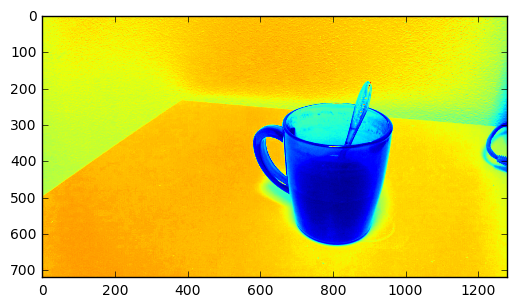

done tmp.pgm to im1.sift
Image 2:


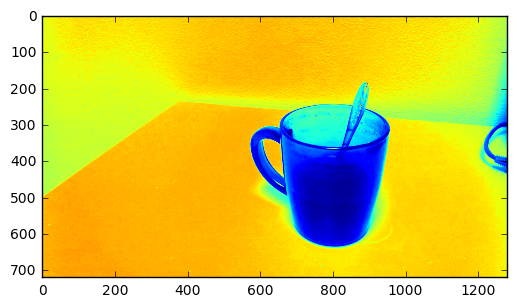

done tmp.pgm to im2.sift


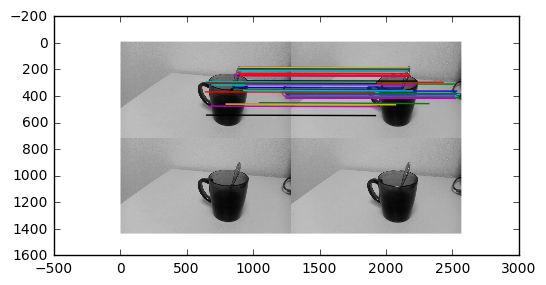

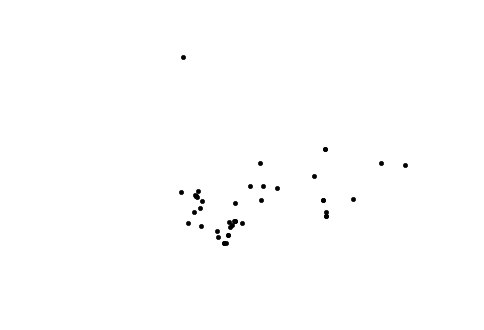

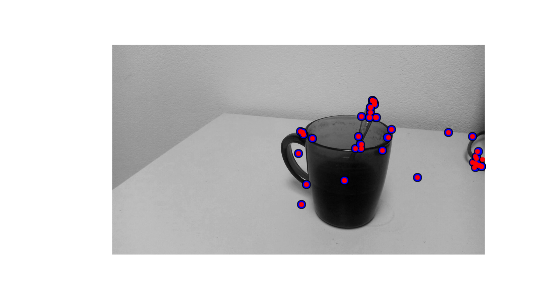

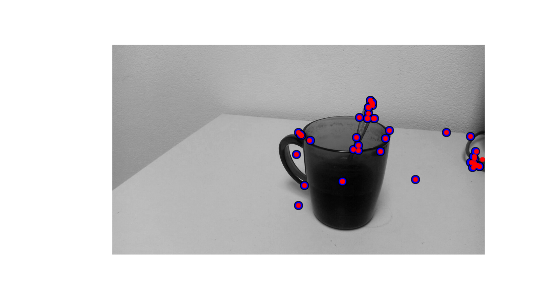

In [3]:
import camera
import numpy as np
import homography
import sfm
from matplotlib.pyplot import figure, gray, show
import random
from PIL import Image
import os
from matplotlib.pyplot import plot, imshow, axis
%matplotlib inline


def calibration(sz):
    dX, dY, dZ = 135, 190, 300    
    sizeX, sizeY = 809, 1079
    dx, dy = 457, 639
    fx, fy = dx / dX * dZ, dy / dY * dZ

    row, col = sz
    fx *= col / sizeX
    fy *= fy * row / sizeY
    K = np.diag([fx, fy, 1])
    K[0, 2] = 0.5 * col
    K[1, 2] = 0.5 * row
    return K


def process_image(imgName, resName, 
                  params="--edge-thresh 10 --peak-thresh 5"):
    if imgName[-3:] != 'pgm':
        img = Image.open(imgName).convert('L')
        img.save('tmp.pgm')
        imgName = 'tmp.pgm'
    cmd = str("sift.exe " + imgName + " --output=" + resName +
               " " + params)
    os.system(cmd)
    print('done', imgName, 'to', resName)

    
def read_features(fileName):
    f = np.loadtxt(fileName)
    return f[:, :4], f[:, 4:]


def match_two_sided(desc1, desc2):
    mat_12 = match(desc1, desc2)
    mat_21 = match(desc2, desc1)
    ndx_12 = mat_12.nonzero()[0]
    for n in ndx_12:
        if mat_21[int(mat_12[n])] != n:
            mat_12[n] = 0
    return mat_12


def match(desc1, desc2):
    desc1 = np.array([d / np.linalg.norm(d) for d in desc1])
    desc2 = np.array([d / np.linalg.norm(d) for d in desc2])
    dist_ratio = 0.6
    desc1_size = desc1.shape
    matchscores = np.zeros((desc1_size[0], 1), 'int')
    desc2t = desc2.T
    for i in range(desc1_size[0]):
        dotprods = np.dot(desc1[i, :], desc2t)
        dotprods = 0.9999 * dotprods
        indx = np.argsort(np.arccos(dotprods))
        if np.arccos(dotprods)[indx[0]] < dist_ratio * np.arccos(dotprods)[indx[1]]:
            matchscores[i] = int(indx[0])
    return matchscores


def append_images(img1, img2):
    rows1 = img1.shape[0]
    rows2 = img2.shape[0]
    if rows1 < rows2:
        img1 = np.concatenate((img1, np.zeros((rows2 - rows1, img1.shape[1]))), axis=0)
    elif rows1 > rows2:
        img2 = np.concatenate((img2, np.zeros((rows1 - rows2, img2.shape[1]))), axis=0)
    return np.concatenate((img1, img2), axis=1)


def plot_matches(img1, img2, locs1, locs2, matchscores, show_below=True):
    img3 = append_images(img1, img2)
    if show_below:
        img3 = np.vstack((img3, img3))
    imshow(img3, cmap='gray')
    cols1 = img1.shape[1]
    for i, ms in enumerate(matchscores):
        for m in ms:
            if m > 0:
                plot([locs1[i][0], locs2[m][0] + cols1], [locs1[i][1], locs2[m][1]], random.choice(('b', 'g', 'r', 'c', 'm', 'y', 'k')))

                
img1Path = "img1.jpg"
img2Path = "img2.jpg"

img1 = np.array(Image.open(img1Path).convert('L'))
print("Image 1:")
imshow(img1)
show()

process_image(img1Path, 'im1.sift')
l1, d1 = read_features("im1.sift")

img2 = np.array(Image.open(img2Path).convert('L'))
print("Image 2:")
imshow(img2)
show()

process_image(img2Path, 'im2.sift')
l2, d2 = read_features("im2.sift")


K = calibration(img1.shape)

matches = match_two_sided(d1, d2)
plot_matches(img1, img2, l1, l2, matches)
ndx = matches.nonzero()[0]

x1 = homography.make_homog(l1[ndx, :2].T)
ndx2 = [int(matches[i]) for i in ndx]
x2 = homography.make_homog(l2[ndx2, :2].T)

x1n = np.dot(np.linalg.inv(K), x1)
x2n = np.dot(np.linalg.inv(K), x2)

model = sfm.RansacModel()
E, inliers = sfm.F_from_ransac(x1n, x2n, model)

P1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
P2 = sfm.compute_P_from_essential(E)


ind = 0
maxres = 0
for i in range(4):
    X = sfm.triangulate(x1n[:, inliers], x2n[:, inliers], P1, P2[i])
    d1 = np.dot(P1, X)[2]
    d2 = np.dot(P2[i], X)[2]
    if sum(d1 > 0) + sum(d2 > 0) > maxres:
        maxres = sum(d1 > 0) + sum(d2 > 0)
        ind = i
        infront = (d1 > 0) & (d2 > 0)

X = sfm.triangulate(x1n[:, inliers], x2n[:, inliers], P1, P2[ind])
X = X[:, infront]


fig = figure()
ax = fig.gca(projection='3d')
ax.plot(-X[0], X[1], X[2], 'k.')
axis('off')

x1_p = camera.Camera(P1).project(X)
x2_p = camera.Camera(P2[ind]).project(X)

x1_p = np.dot(K, x1_p)
x2_p = np.dot(K, x2_p)
figure()
imshow(img1)
gray()
plot(x1_p[0], x1_p[1], 'o')
plot(x1[0], x1[1], 'r.')
axis('off')
figure()
imshow(img2)
gray()
plot(x2_p[0], x2_p[1], 'o')
plot(x2[0], x2[1], 'r.')
axis('off')
show()